In [1]:
# -*- coding: utf-8 -*-
"""
This notebook downloads 10 years of weekly market data for various ETFs using yfinance.
It retrieves data for US stocks, US bonds, developed market stocks (excluding the US),
developed market bonds (excluding the US), emerging market stocks, emerging market bonds, and gold.
The data is saved to a CSV file named 'weekly_market_data_20yr.csv'.
"""

import sys
import subprocess
import os

# Check and install required libraries
required_libraries = [
    "yfinance", "pandas", "pandas_datareader", "tabulate", "matplotlib",
    "numpy", "seaborn", "arch", "plotly", "statsmodels", "pandas_datareader", "nbformat",
    "nbconvert", "ipykernel", "ipywidgets", "scipy", "statsmodels", 'kaleido', 'io'
]
missing_libraries = []

for lib in required_libraries:
    try:
        __import__(lib)
    except ImportError:
        missing_libraries.append(lib)

if missing_libraries:
    print(f"Missing libraries: {', '.join(missing_libraries)}. Installing...")
    for lib in missing_libraries:
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib])
else:
    print("All required libraries are installed.")

from pathlib import Path
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, timedelta
from tabulate import tabulate
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-muted")  # or "bmh", "ggplot", etc.
plt.rcParams.update({
    "font.size": 10,
    "font.family": "sans-serif",
    "axes.titleweight": "bold",
    "axes.labelsize": 8,
    "axes.titlesize": 14,
    "grid.alpha": 0.3,
    "legend.frameon": False,
    "figure.dpi": 100
})

import numpy as np
import seaborn as sns
from arch import arch_model
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import plotly.offline as pyo
import statsmodels.api as sm

import io
from io import StringIO
from contextlib import redirect_stdout
from matplotlib.backends.backend_pdf import PdfPages

All required libraries are installed.


In [2]:
# Utility functions and initialization for figure collection and PDF report generation

figures = []
stdout_buffer = io.StringIO()

def generate_pdf_report(figures, text_pages=None, filename="exports/portfolio_summary_report.pdf"):
    """
    Save a list of matplotlib figures and optional text pages to a single PDF report.

    Parameters:
    - figures (list): List of matplotlib Figure objects.
    - text_pages (list): Optional list of strings to render as pages of text.
    - filename (str): Output PDF file path.
    """
    pdf_path = Path(filename)
    pdf_path.parent.mkdir(parents=True, exist_ok=True)

    with PdfPages(pdf_path) as pdf:
        # Save all figure pages
        for fig in figures:
            pdf.savefig(fig)
            plt.close(fig)

        # Save text pages if provided
        if text_pages:
            for text in text_pages:
                fig_text = plt.figure(figsize=(8.5, 11))
                plt.axis('off')
                plt.text(0, 1, text, fontsize=10, verticalalignment='top', fontfamily='monospace')
                pdf.savefig(fig_text)
                plt.close(fig_text)

    return str(pdf_path)

In [3]:
# Read file
with open("port_details.txt", "r") as file:
    lines = file.readlines()

tickers = {}
constraints = {}
risk_free_rate = None

# Parse content
section = None
for line in lines:
    line = line.strip()
    if not line:
        continue  # skip empty lines
    elif line.endswith(":") and line.count(":") == 1:
        section = line[:-1]
    elif section == "Tickers":
        key, value = line.split(": ")
        tickers[key.strip()] = value.strip()
    elif section == "Risk-free Rate":
        risk_free_rate = float(line.strip())
    elif section == "Investment Constraints":
        if "<=" in line:
            key, value = line.split(" <= ")
            key = key.strip().rstrip(":")
            value = float(value.strip().strip("%")) / 100
            constraints.setdefault(key, {})["max"] = value
        elif ">=" in line or ">" in line:
            key, value = line.split(" > ")
            key = key.strip().rstrip(":")
            value = float(value.strip().strip("%")) / 100
            constraints.setdefault(key, {})["min"] = value

# Define 10-year date range
end_date = end_date = datetime(2025, 6, 13)
start_date = end_date - timedelta(weeks=52 * 10)

# Download weekly close data
data = yf.download(
    tickers=list(tickers.values()),
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    interval="1wk",
    auto_adjust=False,
    back_adjust=False
    )["Close"]

# Rename columns in alphabetical order of tickers
ticker_to_asset = {v: k for k, v in tickers.items()}
data = data.rename(columns=ticker_to_asset)
priority = ['US_Stocks', 'US_Bonds', 'Dev_Stocks_ExUS', 'Dev_Bonds_ExUS',
            'EM_Stocks', 'EM_Bonds', 'Cash']
rest = [col for col in data.columns if col not in priority]
data = data[priority + rest]


# Save to CSV
os.makedirs("exports", exist_ok=True)
data.to_csv("exports/weekly_market_data_10yr_combined.csv") 
print("Saved as 'weekly_market_data_10yr_combined.csv' in exports directory.")

with redirect_stdout(stdout_buffer):
    print("\nData Columns:")
    print(", ".join(data.columns))

    # Output results
    print("\nParsed Portfolio Details:")
    print("Tickers:", tickers)
    print("Risk-Free Rate:", risk_free_rate)
    print("Constraints:", constraints)
    
print("\nData Columns:")
print(", ".join(data.columns))

# Output results
print("\nParsed Portfolio Details:")
print("Tickers:", tickers)
print("Risk-Free Rate:", risk_free_rate)
print("Constraints:", constraints)

[*********************100%***********************]  8 of 8 completed

Saved as 'weekly_market_data_10yr_combined.csv' in exports directory.

Data Columns:
US_Stocks, US_Bonds, Dev_Stocks_ExUS, Dev_Bonds_ExUS, EM_Stocks, EM_Bonds, Cash, Gold

Parsed Portfolio Details:
Tickers: {'US_Stocks': 'VOO', 'US_Bonds': 'AGG', 'Dev_Stocks_ExUS': 'SCHF', 'Dev_Bonds_ExUS': 'BNDX', 'EM_Stocks': 'VWO', 'EM_Bonds': 'EMB', 'Cash': 'BIL', 'Gold': 'GLD'}
Risk-Free Rate: 0.0441
Constraints: {'US_Stocks': {'max': 0.65, 'min': 0.1}, 'US_Bonds': {'max': 0.5, 'min': 0.1}, 'Dev_Stocks_ExUS': {'max': 0.4}, 'Dev_Bonds_ExUS': {'max': 0.4}, 'EM_Bonds': {'max': 0.15}, 'EM_Stocks': {'max': 0.15}, 'Cash': {'max': 0.1, 'min': 0.05}, 'Gold': {'max': 0.15, 'min': 0.05}}


In [4]:
# Create interactive line chart for ETF prices
fig = go.Figure()
for col in data.columns:
    fig.add_trace(go.Scatter(x=data.index, y=data[col], mode='lines', name=col))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    hovermode='x unified',
    template='plotly_white',
    font=dict(family="sans-serif", size=12),
    title=dict(text='10-Year Weekly Prices of ETFs (Interactive)', font=dict(size=16)),
    legend=dict(title="Asset Class"),
    width=1100,
    height=850
)
pyo.iplot(fig)
pio.write_image(fig, "exports/asset_prices_10_years.png", width=1100, height=850)


# Calculate simple weekly returns
# Drop the first row to avoid NaN values in returns calculation
simple_returns = data.pct_change().dropna()

# Cumulative returns from normalized starting point (100)
cumulative_returns = (1 + simple_returns).cumprod() * 100

fig = go.Figure()

for col in cumulative_returns.columns:
    fig.add_trace(go.Scatter(x=cumulative_returns.index, y=cumulative_returns[col], mode='lines', name=col))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Cumulative Value',
    hovermode='x unified',
    template='plotly_white',
    font=dict(family="sans-serif", size=12),
    title=dict(text='Cumulative Returns of Assets (Base = 100)', font=dict(size=16)),
    legend=dict(title="Asset Class"),
    width=1100,
    height=850
)

pyo.iplot(fig)
pio.write_image(fig, "exports/cumulative_returns_10_years.png", width=1100, height=850)

# Calculate log weekly returns
# Drop the first row to avoid NaN values in returns calculation
log_returns = np.log(data / data.shift(1)).dropna()

# Cumulative returns from normalized starting point (100) using log returns
# Note: Cumulative returns from log returns are calculated differently 
cum_log_returns = np.exp(log_returns.cumsum()) * 100

# Create a new plotly figure for cumulative log returns
fig_log = go.Figure()

for col in cum_log_returns.columns:
    fig_log.add_trace(go.Scatter(x=cum_log_returns.index, y=cum_log_returns[col], mode='lines', name=col))

fig_log.update_layout(
    xaxis_title='Date',
    yaxis_title='Cumulative Log Value',
    hovermode='x unified',
    template='plotly_white',
    font=dict(family="sans-serif", size=12),
    title=dict(text='Cumulative Log Returns of Assets (Base = 100)', font=dict(size=16)),
    legend=dict(title="Asset Class"),
    width=1100,
    height=850
)

pyo.iplot(fig_log)
pio.write_image(fig, "exports/cumulative_log_returns_10_years.png", width=1100, height=850)

In [5]:
# Descriptive statistics for ETF weekly return series
assets =  data.columns

desc_stats = pd.DataFrame(index=assets)

# Mean (expected return, annualized)
desc_stats['Mean (Ann.)'] = simple_returns.mean() * 52

# Standard deviation (volatility, annualized)
desc_stats['Std Dev (Ann.)'] = simple_returns.std() * np.sqrt(52)

# Skewness (asymmetry)
desc_stats['Skewness'] = simple_returns.skew()

# Kurtosis (fat tails)
desc_stats['Kurtosis'] = simple_returns.kurtosis()

# Max/min weekly returns
desc_stats['Max Return'] = simple_returns.max()
desc_stats['Min Return'] = simple_returns.min()

# Sharpe Ratio (annualized)
desc_stats['Sharpe Ratio'] = (simple_returns.mean() * 52 - risk_free_rate) / (simple_returns.std() * np.sqrt(52))

with redirect_stdout(stdout_buffer):
    print("Descriptive Statistics for ETF Weekly Returns (Annualized where appropriate):")
    print(desc_stats.round(4))

# Select relevant columns for visualization
stats_plot = desc_stats[['Mean (Ann.)', 'Std Dev (Ann.)', 'Skewness', 'Kurtosis', 'Max Return', 'Min Return', 'Sharpe Ratio']]

# Prepare data for plotly
bar_traces = []
for metric in stats_plot.columns:
    bar_traces.append(
        go.Bar(
            x=stats_plot.index,
            y=stats_plot[metric],
            name=metric
        )
    )

fig = go.Figure(data=bar_traces)
fig.update_layout(
    barmode='group',
    title='Descriptive Statistics (Annualized)',  # Shorter title
    xaxis_title='Asset Class',
    yaxis_title='Value',
    legend_title='Metric',
    template='plotly_white',
    font=dict(size=12),
    width=1100,
    height=850
)
pyo.iplot(fig)
pio.write_image(fig, "exports/etf_descriptive_stats.png", width=1100, height=850)

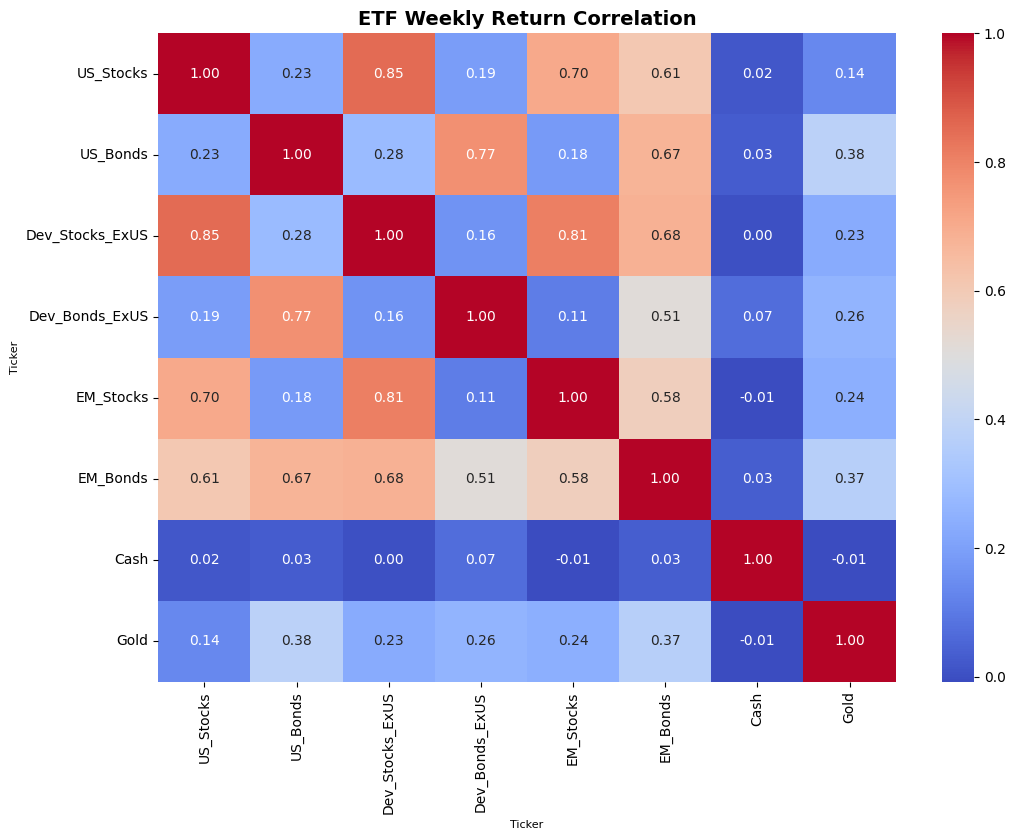

In [6]:
fig_corr = plt.figure(figsize=(11, 8.5))
sns.heatmap(simple_returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("ETF Weekly Return Correlation")
plt.tight_layout()
plt.show()
figures.append(fig_corr)

In [7]:
# Downside and tail risk analysis for each asset class

# 1. Value at Risk (VaR) at 5% level
VaR_5 = simple_returns.quantile(0.05)

# 2. Conditional Value at Risk (CVaR) at 5% level
CVaR_5 = simple_returns[simple_returns.lt(VaR_5)].mean()

# 3. Maximum drawdown
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

max_dd = simple_returns.apply(max_drawdown)

# 4. Beta vs. US Stocks
us_stock_returns = simple_returns['US_Stocks']
betas = {}
for asset in assets:
    if asset == 'US_Stocks':
        betas[asset] = 1.0
    else:
        cov = simple_returns[asset].cov(us_stock_returns)
        var = us_stock_returns.var()
        betas[asset] = cov / var

betas = pd.Series(betas)

# Compile results
risk_stats = pd.DataFrame({
    'VaR (5%)': VaR_5,
    'CVaR (5%)': CVaR_5,
    'Max Drawdown': max_dd,
    'Beta (vs US_Stocks)': betas
})

try:
    garch_vols = {}
    for asset in assets:
        am = arch_model(simple_returns[asset]*100, vol='Garch', p=1, q=1, rescale=False)
        res = am.fit(disp='off')
        garch_vols[asset] = res.conditional_volatility.mean() / 100  # Convert back to original scale
    risk_stats['Avg GARCH Vol'] = pd.Series(garch_vols)
except ImportError:
    print("arch package not installed. Skipping GARCH volatility modeling.")

with redirect_stdout(stdout_buffer):
    print("Downside and Tail Risk Statistics:")
    print(risk_stats.round(4))

# Select relevant columns for visualization
risk_plot = risk_stats[['VaR (5%)', 'CVaR (5%)', 'Max Drawdown', 'Avg GARCH Vol']]

# Prepare data for plotly
bar_traces = []
for metric in risk_plot.columns:
    bar_traces.append(
        go.Bar(
            x=risk_plot.index,
            y=risk_plot[metric],
            name=metric
        )
    )

fig = go.Figure(data=bar_traces)
fig.update_layout(
    barmode='group',
    title='Downside and Tail Risk Metrics by Asset Class (Interactive)',
    xaxis_title='Asset Class',
    yaxis_title='Value',
    legend_title='Metric',
    template='plotly_white',
    width=1100,
    height=850
)
pyo.iplot(fig)
pio.write_image(fig, "exports/downside_tail_risk_metrics.png", width=1100, height=850)

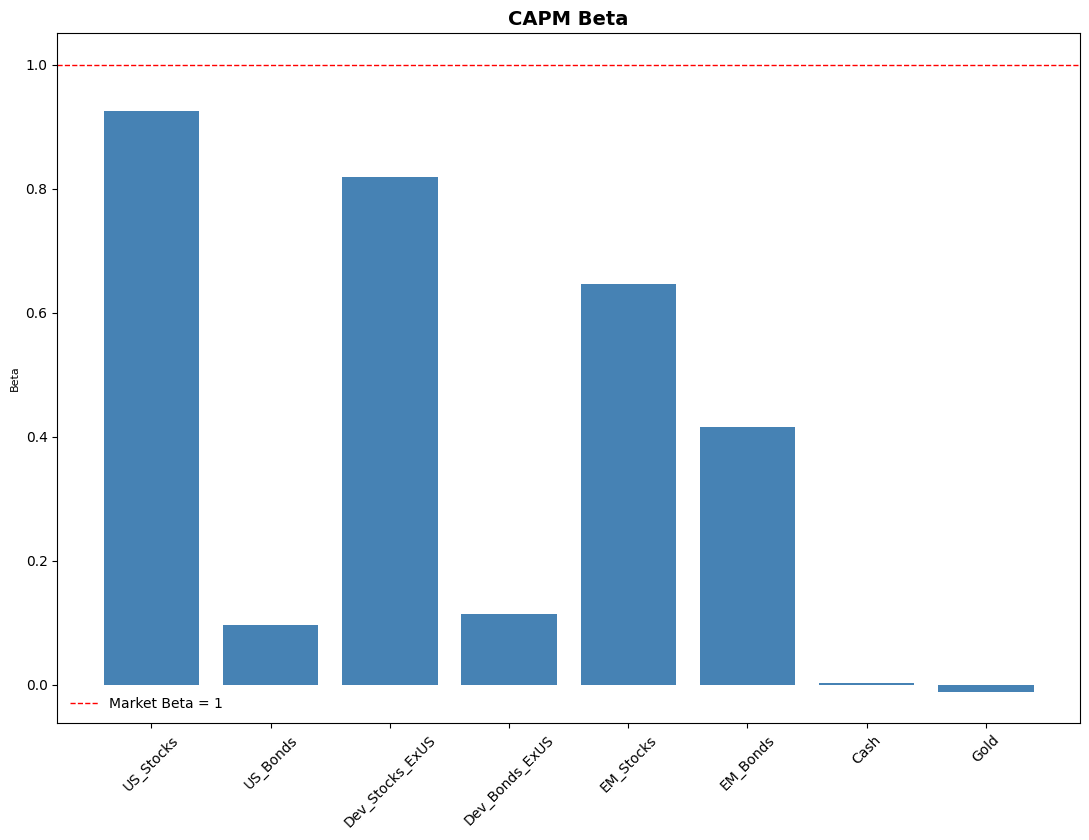

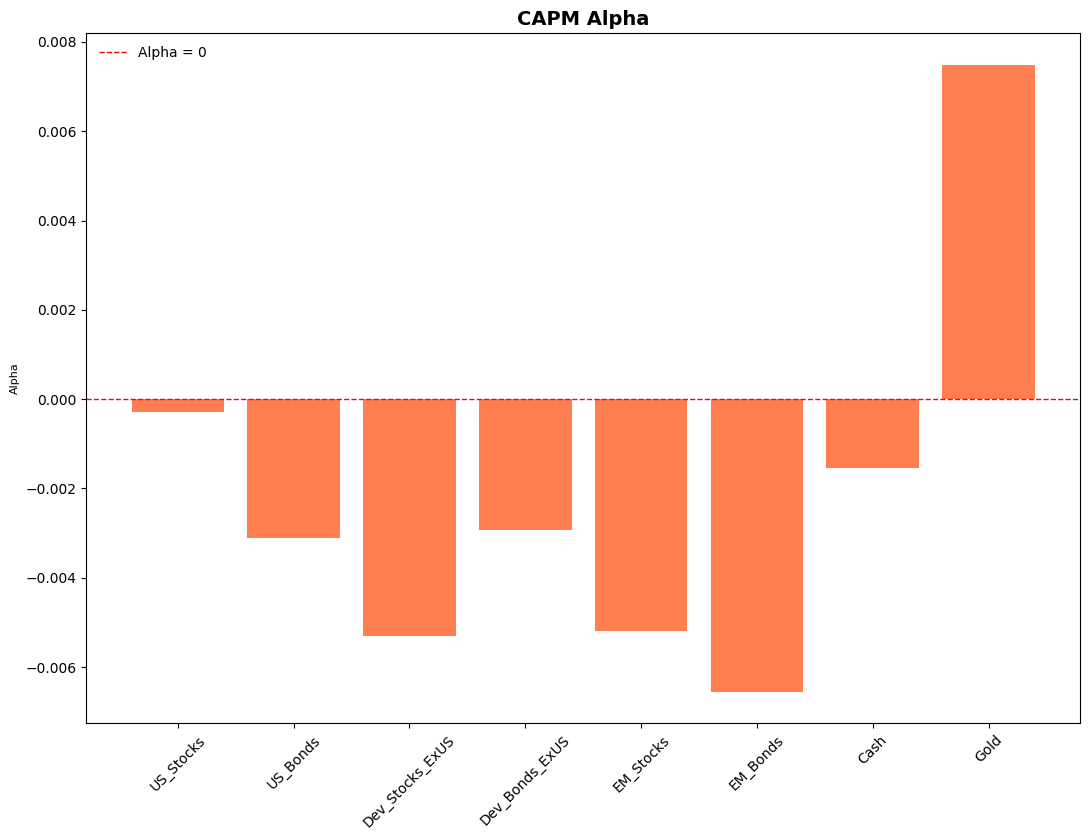

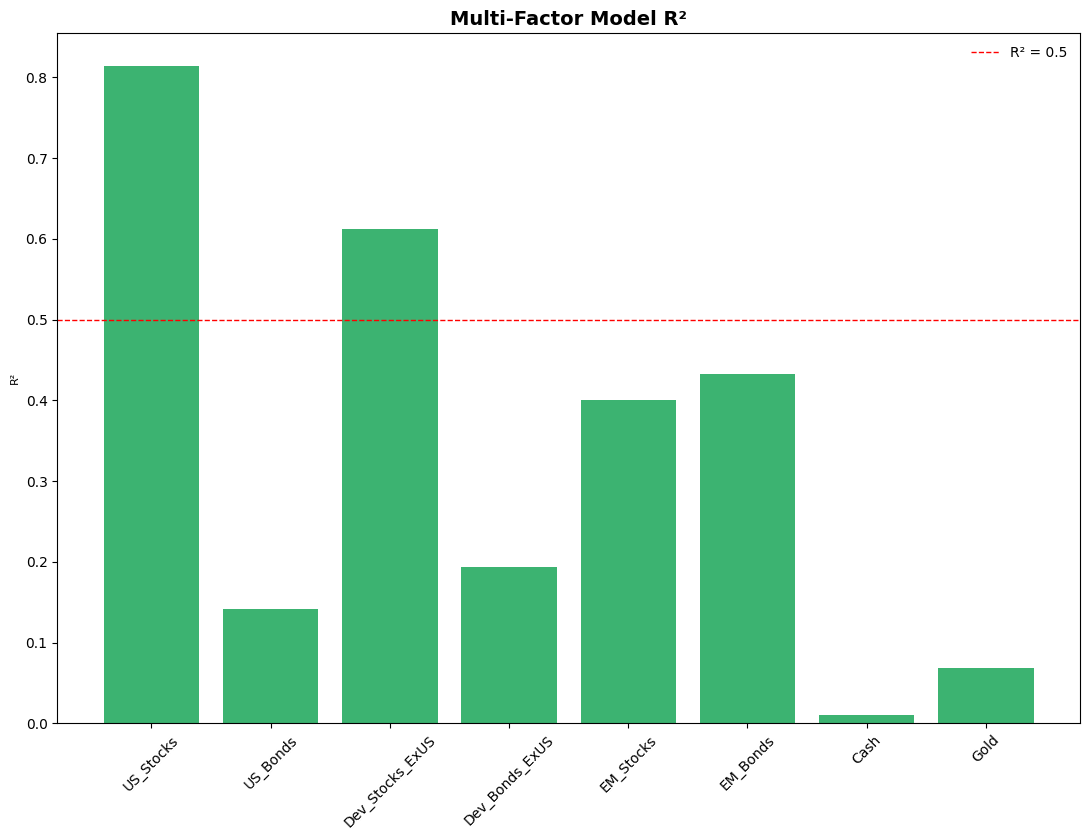

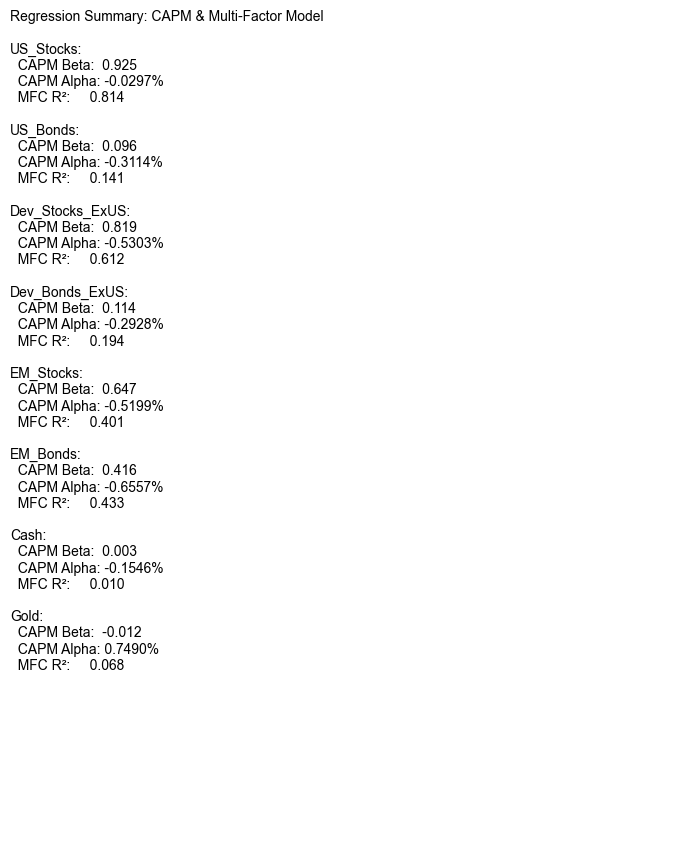

In [8]:
# Calculate monthly returns from weekly data
monthly_returns = simple_returns.resample('ME').apply(lambda x: (1 + x).prod() - 1)
monthly_returns.index = monthly_returns.index.to_period('M').to_timestamp('M') - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)

# Download Fama-French factors and momentum data
# Load local CSVs from Kenneth French (already downloaded and cleaned)
ff_factors = pd.read_csv('data/F-F_Research_Data_Factor.csv', skiprows=3)
momentum = pd.read_csv('data/F-F_Momentum_Factor.csv', skiprows=13)

# Clean and parse dates
ff_factors = ff_factors.rename(columns={ff_factors.columns[0]: 'Date'})
# Keep only rows where 'Date' is a 6-digit string (YYYYMM)
ff_factors = ff_factors[ff_factors['Date'].astype(str).str.match(r'^\d{6}$')]
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m')
# Set datetime as index and convert values to decimal
ff_factors.set_index('Date', inplace=True)
ff_factors = ff_factors.astype(float) / 100

# Optional: Rename for compatibility
ff_factors.columns = ['Mkt_RF', 'SMB', 'HML', 'RF']

momentum = momentum.rename(columns={momentum.columns[0]: 'Date'})
# Keep only rows where 'Date' is a 6-digit string (YYYYMM)
momentum = momentum[momentum['Date'].astype(str).str.match(r'^\d{6}$')]
momentum['Date'] = pd.to_datetime(momentum['Date'], format='%Y%m')
momentum.set_index('Date', inplace=True)
momentum = momentum.astype(float) / 100
momentum = momentum.rename(columns={momentum.columns[0]: 'Mom'})

# Merge with Fama-French data
ff_factors = ff_factors.join(momentum)
ff_factors.columns = ['Mkt_RF', 'SMB', 'HML', 'RF', 'Mom']

# Align dates with your monthly returns
common_end = min(monthly_returns.index.max(), ff_factors.index.max())
ff_factors_aligned = ff_factors.loc[monthly_returns.index.min():common_end]
monthly_returns_aligned = monthly_returns.loc[monthly_returns.index.min():common_end]

# Perform CAPM and Multi-Factor Model regressions
regression_results = {}
capm_betas, capm_alphas, mfc_r2 = [], [], []

for asset in monthly_returns.columns:
    df = pd.concat([monthly_returns[asset], ff_factors_aligned], axis=1).dropna()
    df.columns = ['Ret', 'Mkt_RF', 'SMB', 'HML', 'RF', 'Mom']

    if df.empty:
        print(f"⚠️ Skipping {asset}: no overlapping data.")
        continue

    y = df['Ret'] - df['RF']

    X_capm = sm.add_constant(df['Mkt_RF'])
    capm_model = sm.OLS(y, X_capm).fit()

    X_mfc = sm.add_constant(df[['Mkt_RF', 'SMB', 'HML']])
    mfc_model = sm.OLS(y, X_mfc).fit()

    regression_results[asset] = {'CAPM': capm_model, 'MFC': mfc_model}
    capm_betas.append(capm_model.params['Mkt_RF'])
    capm_alphas.append(capm_model.params['const'])
    mfc_r2.append(mfc_model.rsquared)

regression_assets = monthly_returns.columns.tolist()

# === Plot 1: CAPM Beta ===
fig_capm = plt.figure(figsize=(11, 8.5))
plt.bar(regression_assets, capm_betas, color='steelblue')
plt.title('CAPM Beta', fontsize=14)
plt.ylabel('Beta')
plt.axhline(1, color='red', linestyle='--', linewidth=1, label='Market Beta = 1')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
figures.append(fig_capm)

# === Plot 2: CAPM Alpha ===
fig_alpha = plt.figure(figsize=(11, 8.5))
plt.bar(regression_assets, capm_alphas, color='coral')
plt.title('CAPM Alpha', fontsize=14)
plt.ylabel('Alpha')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Alpha = 0')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
figures.append(fig_alpha)

# === Plot 3: Multi-Factor R² ===
fig_multi = plt.figure(figsize=(11, 8.5))
plt.bar(regression_assets, mfc_r2, color='mediumseagreen')
plt.title('Multi-Factor Model R²', fontsize=14)
plt.ylabel('R²')
plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='R² = 0.5')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
figures.append(fig_multi)

summary_buffer = StringIO()
summary_buffer.write("Regression Summary: CAPM & Multi-Factor Model\n\n")

for asset in regression_assets:
    capm = regression_results[asset]['CAPM']
    mfc = regression_results[asset]['MFC']
    summary_buffer.write(f"{asset}:\n")
    summary_buffer.write(f"  CAPM Beta:  {capm.params['Mkt_RF']:.3f}\n")
    summary_buffer.write(f"  CAPM Alpha: {capm.params['const']:.4%}\n")
    summary_buffer.write(f"  MFC R²:     {mfc.rsquared:.3f}\n\n")

fig_text = plt.figure(figsize=(8.5, 11))
plt.axis('off')
plt.text(0, 1, summary_buffer.getvalue(), fontsize=10, fontfamily='arial', verticalalignment='top')
figures.append(fig_text)

In [9]:
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 52
cov_matrix = returns.cov() * 52

# Portfolio simulation with constraints
num_portfolios = 50000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    while True:
        weights = np.random.random(len(assets))
        weights /= np.sum(weights)

        # Enforce min/max constraints
        valid = True
        for j, asset in enumerate(assets):
            if asset in constraints:
                rule = constraints[asset]
                if 'max' in rule and weights[j] > rule['max']:
                    valid = False
                    break
                if 'min' in rule and weights[j] < rule['min']:
                    valid = False
                    break
        if valid:
            break

    port_return = np.sum(mean_returns * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - risk_free_rate) / port_volatility

    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe
    weights_record.append(weights)

# Find portfolio with max Sharpe ratio
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_record[max_sharpe_idx]
optimal_portfolio = pd.Series(optimal_weights, index=assets)
opt_port = optimal_portfolio.reset_index()
opt_port.columns = ['Asset_Class', 'Weight']


# Calculate optimal portfolio metrics
optimal_volatility = results[1, max_sharpe_idx]
optimal_return = results[0, max_sharpe_idx]
max_sharpe = results[2, max_sharpe_idx]

with redirect_stdout(stdout_buffer):
    # Print optimal allocation
    print("Optimal Portfolio Allocation (with Constraints):")
    print(opt_port.round(4))
    print(f"Expected Annual Return: {optimal_return:.4f}")
    print(f"Expected Annual Volatility: {optimal_volatility:.4f}")  
    print(f"Max Sharpe Ratio: {max_sharpe:.4f}")

    for asset, weight in zip(assets, optimal_weights):
        if asset in constraints:
            rule = constraints[asset]
            if 'min' in rule and weight < rule['min']:
                print(f"❌ {asset} violates MIN: {weight:.4f} < {rule['min']}")
            if 'max' in rule and weight > rule['max']:
                print(f"❌ {asset} violates MAX: {weight:.4f} > {rule['max']}")

# Save optimal portfolio to CSV

opt_port.to_csv("exports/optimal_portfolio_with_constraints.csv")
print("Optimal portfolio saved as 'optimal_portfolio_with_constraints.csv' in exports directory.")

Optimal portfolio saved as 'optimal_portfolio_with_constraints.csv' in exports directory.


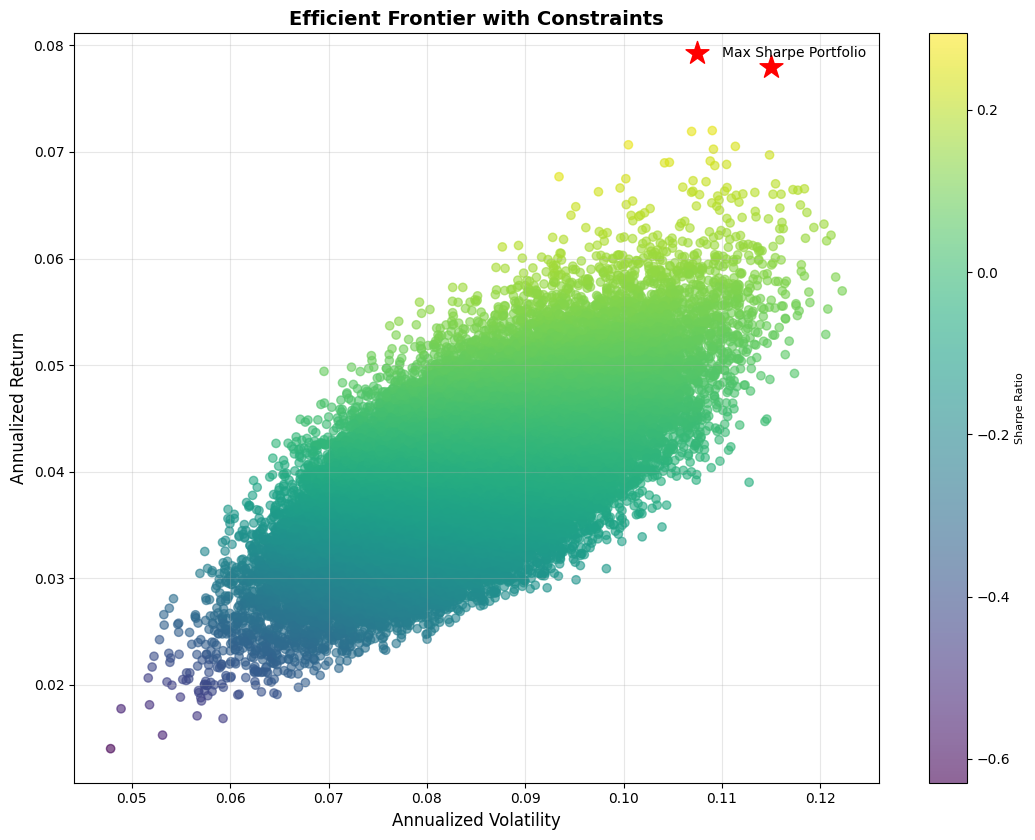

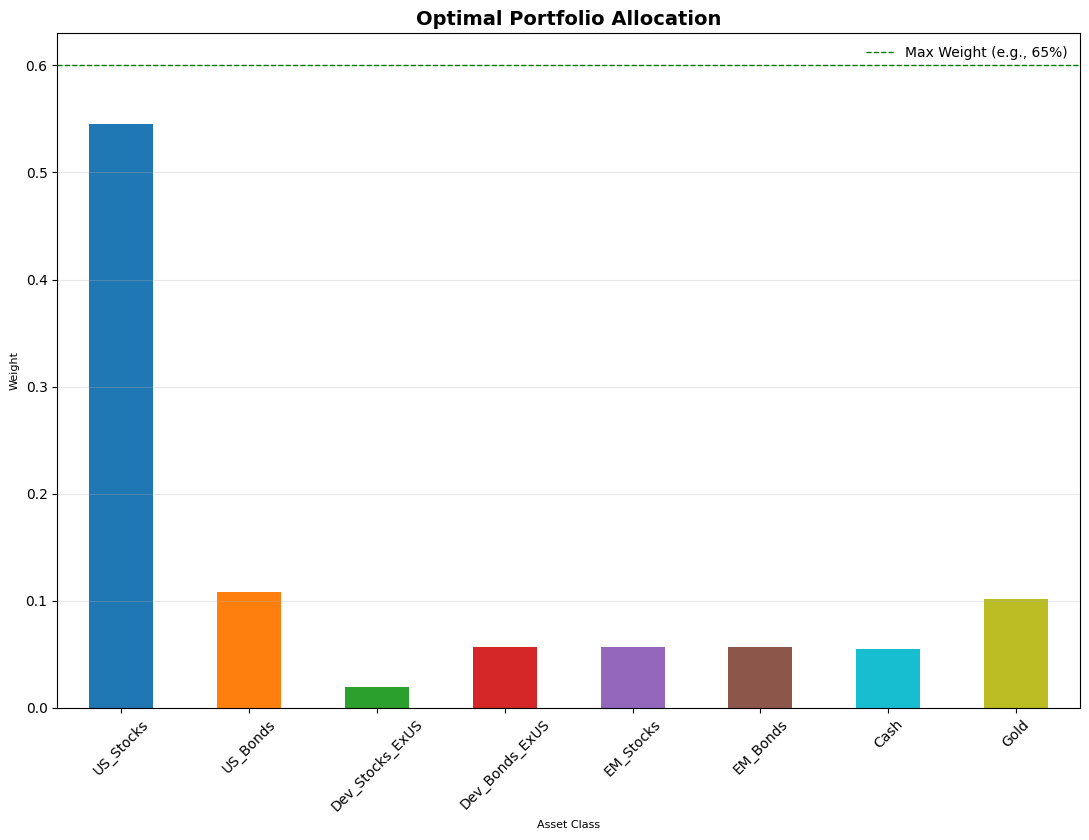

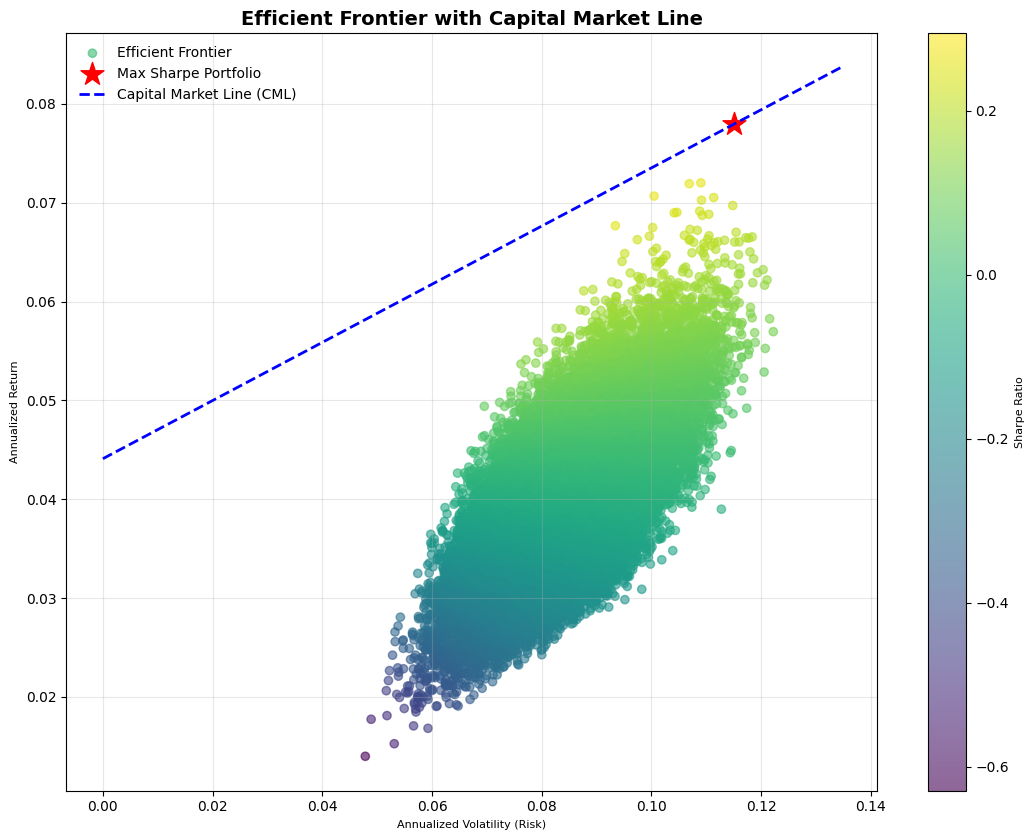

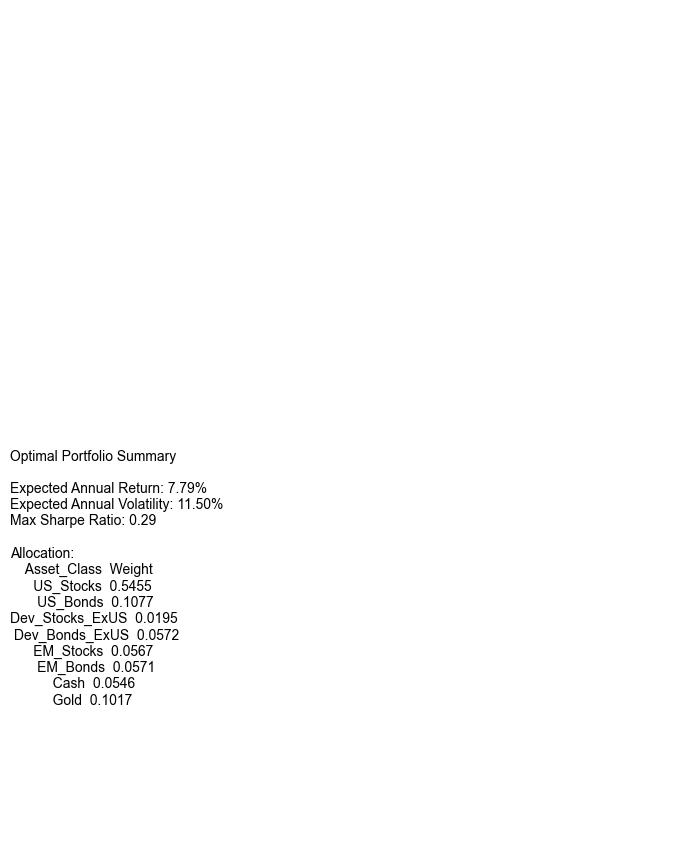

In [ ]:
# Plot efficient frontier
fig1 = plt.figure(figsize=(11, 8.5))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=300, label='Max Sharpe Portfolio')
plt.title("Efficient Frontier with Constraints", fontsize=14)
plt.xlabel("Annualized Volatility", fontsize=12)
plt.ylabel("Annualized Return", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
figures.append(fig1)

colors = {
    'US_Stocks': '#1f77b4', 'US_Bonds': '#ff7f0e', 'Dev_Stocks_ExUS': '#2ca02c',
    'Dev_Bonds_ExUS': '#d62728', 'EM_Stocks': '#9467bd', 'EM_Bonds': '#8c564b',
    'Cash': '#17becf', 'Gold': '#bcbd22', 'Crypto': '#e377c2'
}
bar_colors = [colors.get(asset, '#333333') for asset in optimal_portfolio.index]

fig2 = plt.figure(figsize=(11, 8.5))
optimal_portfolio.plot(kind='bar', color=bar_colors, figsize=(11, 8.5))
plt.title("Optimal Portfolio Allocation", fontsize=14)
plt.ylabel("Weight")
plt.xlabel("Asset Class")
plt.grid(axis='y')
plt.axhline(y=0.6, color='green', linestyle='--', linewidth=1, label='Max Weight (e.g., 65%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
figures.append(fig2)

# Define x-axis range: from 0 to a bit beyond the optimal volatility
x = np.linspace(0, max(results[1]) * 1.1, 100)

# CML equation: R = Rf + Sharpe * σ
cml = risk_free_rate + max_sharpe * x

# Plot Efficient Frontier
fig3 = plt.figure(figsize=(11, 8.5))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', alpha=0.6, label='Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=300, label='Max Sharpe Portfolio')
plt.plot(x, cml, color='blue', linestyle='--', linewidth=2, label='Capital Market Line (CML)')
plt.title("Efficient Frontier with Capital Market Line")
plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
figures.append(fig3)

fig_text = plt.figure(figsize=(8.5, 11))
text = f"""
Optimal Portfolio Summary

Expected Annual Return: {optimal_return:.2%}
Expected Annual Volatility: {optimal_volatility:.2%}
Max Sharpe Ratio: {max_sharpe:.2f}

Allocation:
{opt_port.round(4).to_string(index=False)}
"""
plt.axis('off')
plt.text(0, 1, text, fontsize=10, verticalalignment='top', fontfamily='arial')
figures.append(fig_text)

In [12]:
min_var_idx = np.argmin(results[1])  # lowest volatility
min_var_vol = results[1][min_var_idx]
min_var_ret = results[0][min_var_idx]
min_var_sharpe = results[2][min_var_idx]
min_var_weights = weights_record[min_var_idx]
min_var_portfolio = pd.Series(min_var_weights, index=assets)

with redirect_stdout(stdout_buffer):
    print("\nMinimum Volatility Portfolio (No Constraints):")
    print(min_var_portfolio.round(4))
    print(f"Minimum Volatility Portfolio")
    print(f"Expected Annual Return: {min_var_ret:.4f}")
    print(f"Expected Annual Volatility: {min_var_vol:.4f}")
    print(f"Max Sharpe Ratio: {min_var_sharpe:.4f}")

In [13]:
# Identify indices of Max Sharpe and Min Variance portfolios
#    results[0, i] = port_return
#    results[1, i] = port_volatility
#    results[2, i] = sharpe

sharpe_ratios = results[2]
portfolio_returns = results[0]
portfolio_vols = results[1]

max_sharpe_idx = np.argmax(sharpe_ratios)
min_var_idx = np.argmin(portfolio_vols)

# Extract weights
max_sharpe_weights = weights_record[max_sharpe_idx]
min_var_weights = weights_record[min_var_idx]

# Extract stats
max_sharpe_return = portfolio_returns[max_sharpe_idx]
max_sharpe_vol = portfolio_vols[max_sharpe_idx]
max_sharpe_ratio = sharpe_ratios[max_sharpe_idx]

min_var_return = portfolio_returns[min_var_idx]
min_var_vol = portfolio_vols[min_var_idx]
min_var_ratio = sharpe_ratios[min_var_idx]

mvp_df = pd.DataFrame({
    "Asset": list(tickers.keys()),
    "Weight": min_var_weights
}).set_index("Asset")
mvp_df.loc["Total"] = mvp_df.sum()

tangency_df = pd.DataFrame({
    "Asset": list(tickers.keys()),
    "Weight": max_sharpe_weights
}).set_index("Asset")
tangency_df.loc["Total"] = tangency_df.sum()

with redirect_stdout(stdout_buffer):
    print("\nMinimum Variance Portfolio Weights:")
    print("Minimum Variance Portfolio:")
    print(mvp_df.round(4))
    print(f"Return: {min_var_return:.4%} | Volatility: {min_var_vol:.4%} | Sharpe Ratio: {min_var_ratio:.2f}")
    print("\nMaximum Sharpe Portfolio:")
    print(tangency_df.round(4))
    print(f"Return: {max_sharpe_return:.4%} | Volatility: {max_sharpe_vol:.4%} | Sharpe Ratio: {max_sharpe_ratio:.2f}")

In [ ]:
captured_output = stdout_buffer.getvalue()

fig_prints = plt.figure(figsize=(8.5, 11))
plt.axis('off')
plt.text(0, 1, captured_output, fontsize=7, fontfamily='arial', verticalalignment='top', 
         wrap=True)
figures.append(fig_prints)

generate_pdf_report(figures)

'exports\\portfolio_summary_report.pdf'